# COMP3134 BI & CRM Project – Group 6 Notebook

This notebook is organized as: Data Loading → Data Quality & Validation → Transformation & Fact Table → Exploratory Data Analysis (EDA) → Feature Engineering → Modeling (Customer Segmentation) → Insights & Marketing Strategy → Export Results.

Source files (same folder):
- sales_6.csv
- customers_6.csv
- products_6.csv

All code is fully reproducible. If any dependency is missing, please install them as described in the README.

In [1]:
# Environment & Imports
# If packages are missing, refer to README or install via pip in this notebook (may need kernel restart).
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: uncomment for interactive charts
# import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Optional: association rule mining (future extension)
# from mlxtend.frequent_patterns import apriori, association_rules

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Pandas: 2.2.2
NumPy: 1.26.4


In [2]:
# File Paths & Data Loading
DATA_DIR = Path('./data')  # current directory
sales_file = DATA_DIR / 'sales_6.csv'
customers_file = DATA_DIR / 'customers_6.csv'
products_file = DATA_DIR / 'products_6.csv'

# Load raw data
sales_raw = pd.read_csv(sales_file)
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)

print('Sales shape:', sales_raw.shape)
print('Customers shape:', customers.shape)
print('Products shape:', products.shape)

# Quick preview
display(sales_raw.head())
display(customers.head())
display(products.head())

Sales shape: (4348, 5)
Customers shape: (1178, 4)
Products shape: (535, 3)


,Invoice no,Customer id,Product id list,Invoice date,Shopping mall
0,INV00001,C00712,P00442,25/12/2025,MK
1,INV00002,C00168,"P00270,P00442",16/05/2024,CYB
2,INV00003,C00904,"P00530,P00355,P00522,P00224",01/07/2024,ST
3,INV00004,C01112,P00157,31/03/2025,TKO
4,INV00005,C00361,"P00160,P00020,P00116,P00165",09/08/2024,ST


,Customer id,Gender,Age,Payment method
0,C00001,M,19,Credit Card
1,C00002,M,47,Cash
2,C00003,M,51,Cash
3,C00004,M,31,Cash
4,C00005,M,27,Cash


,Product id,Category,Price
0,P00001,Groceries,232.56
1,P00002,Electronics,5462.98
2,P00003,Groceries,166.36
3,P00004,Electronics,1561.48
4,P00005,Books,279.14


## Data Validation & Basic Checks
- Check column formats & missing values
- Validate ID formats (Invoice / Customer / Product)
- Parse date format (DD/MM/YYYY)
- Basic stats & cardinalities

In [3]:
# Basic data quality checks and type handling
print("Missing values (sales):")
print(sales_raw.isna().sum())
print("Missing values (customers):")
print(customers.isna().sum())
print("Missing values (products):")
print(products.isna().sum())

# Format validation (simple examples)
invoice_format_ok = sales_raw['Invoice no'].str.match(r'^INV\d{5}$').all()
customer_format_ok = customers['Customer id'].str.match(r'^C\d{5}$').all()
product_format_ok = products['Product id'].str.match(r'^P\d{5}$').all()
print('Invoice format valid:', invoice_format_ok)
print('Customer format valid:', customer_format_ok)
print('Product format valid:', product_format_ok)

# Date parsing
sales_raw['Invoice date'] = pd.to_datetime(sales_raw['Invoice date'], format='%d/%m/%Y', errors='coerce')
print('Earliest date:', sales_raw['Invoice date'].min(), 'Latest date:', sales_raw['Invoice date'].max())

# Unique values overview
print('Shopping mall unique values:', sales_raw['Shopping mall'].unique())
print('Gender unique values:', customers['Gender'].unique())
print('Payment method unique values:', customers['Payment method'].unique())

Missing values (sales):
Invoice no         0
Customer id        0
Product id list    0
Invoice date       0
Shopping mall      0
dtype: int64
Missing values (customers):
Customer id       0
Gender            0
Age               0
Payment method    0
dtype: int64
Missing values (products):
Product id    0
Category      0
Price         0
dtype: int64
Invoice format valid: True
Customer format valid: True
Product format valid: True
Earliest date: 2024-01-01 00:00:00 Latest date: 2025-12-31 00:00:00
Shopping mall unique values: ['MK' 'CYB' 'ST' 'TKO']
Gender unique values: ['M' 'F']
Payment method unique values: ['Credit Card' 'Cash' 'Mobile Payment']


In [4]:
# Transaction line expansion: split multi-product column
# Assume column name is 'Product id list'
if 'Product id list' in sales_raw.columns:
    exploded = (sales_raw.assign(ProductList=sales_raw['Product id list'].str.split(','))
                          .explode('ProductList'))
    exploded['ProductList'] = exploded['ProductList'].str.strip()
else:
    exploded = sales_raw.copy()
    exploded['ProductList'] = np.nan

# Join product & customer attributes
merged = (exploded
          .merge(products, left_on='ProductList', right_on='Product id', how='left')
          .merge(customers, on='Customer id', how='left'))

print('Merged shape:', merged.shape)
display(merged.head())

# Line amount (if each row is one unit at listed Price)
if 'Price' in merged.columns:
    merged['LineAmount'] = merged['Price']

# Invoice-level total
invoice_amount = merged.groupby('Invoice no')['LineAmount'].sum().reset_index(name='InvoiceAmount')
merged = merged.merge(invoice_amount, on='Invoice no', how='left')

Merged shape: (13032, 12)


,Invoice no,Customer id,Product id list,Invoice date,Shopping mall,ProductList,Product id,Category,Price,Gender,Age,Payment method
0,INV00001,C00712,P00442,2025-12-25,MK,P00442,P00442,Toys,129.62,F,39,Cash
1,INV00002,C00168,"P00270,P00442",2024-05-16,CYB,P00270,P00270,Electronics,1546.75,M,22,Credit Card
2,INV00002,C00168,"P00270,P00442",2024-05-16,CYB,P00442,P00442,Toys,129.62,M,22,Credit Card
3,INV00003,C00904,"P00530,P00355,P00522,P00224",2024-07-01,ST,P00530,P00530,Clothing,975.60,M,25,Cash
4,INV00003,C00904,"P00530,P00355,P00522,P00224",2024-07-01,ST,P00355,P00355,Books,236.37,M,25,Cash


## Exploratory Data Analysis (EDA)
Goal: identify high-value customer segments, popular categories, and mall differences to inform marketing strategy.
Suggested metrics:
- Total sales / Sales by mall
- Category revenue ranking
- Distribution of average order value (InvoiceAmount)
- Gender / Age distribution
- Monthly trend & seasonality

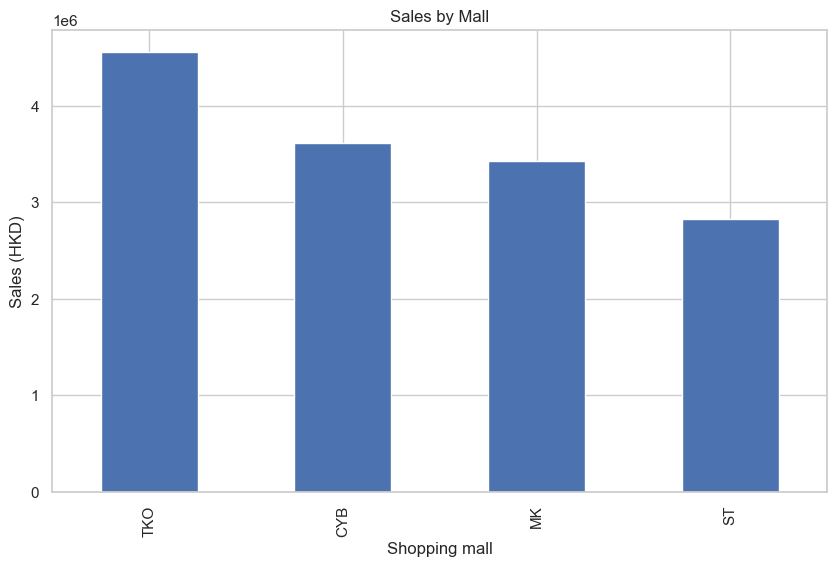

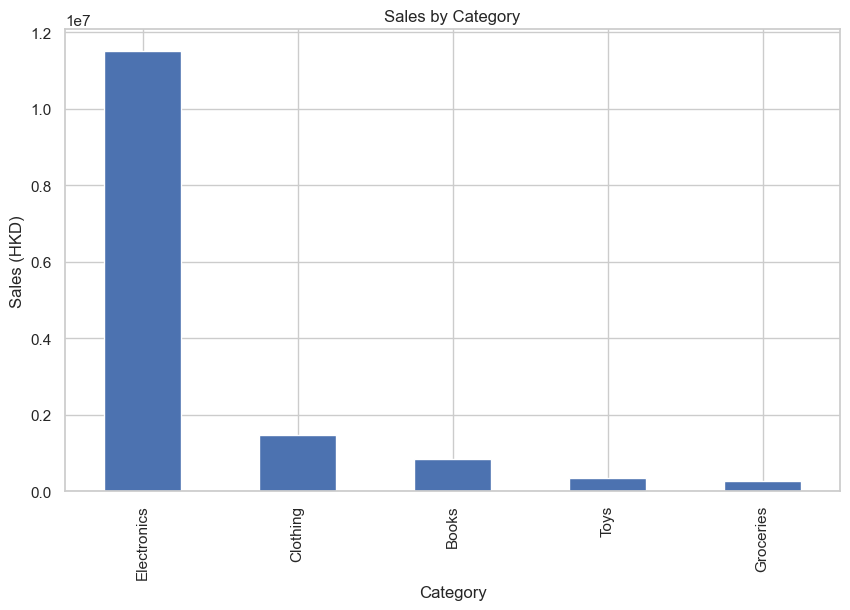

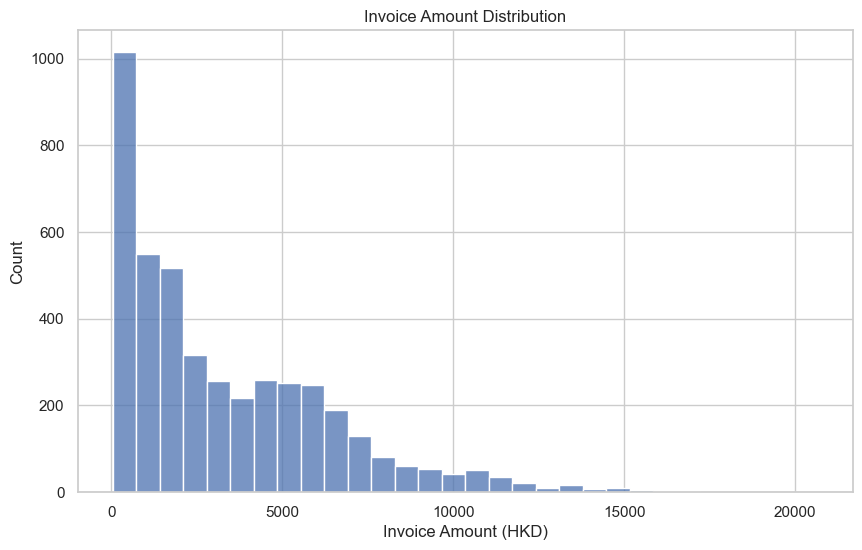

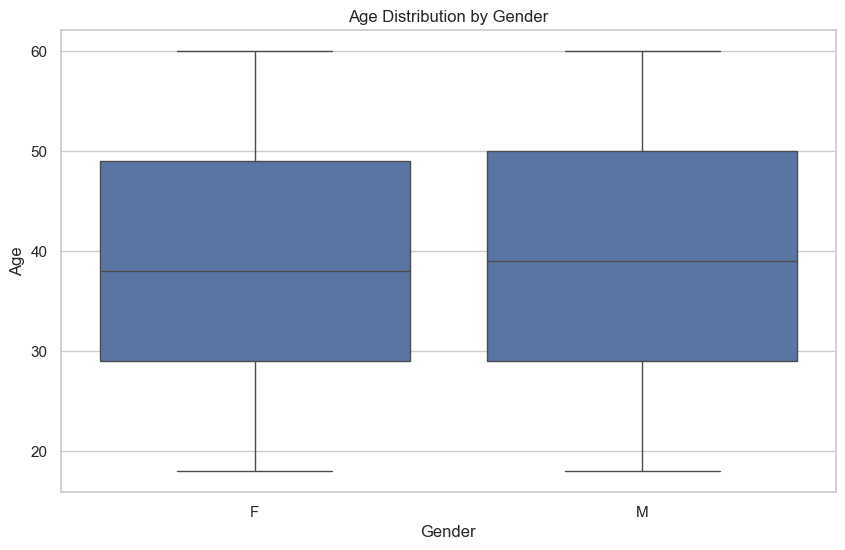

In [5]:
# EDA examples: mall sales, category sales, order value distribution
# Mall sales
if 'LineAmount' in merged.columns:
    mall_sales = merged.groupby('Shopping mall')['LineAmount'].sum().sort_values(ascending=False)
    mall_sales.plot(kind='bar', title='Sales by Mall')
    plt.ylabel('Sales (HKD)')
    plt.show()

# Category sales
if 'Category' in merged.columns and 'LineAmount' in merged.columns:
    category_sales = merged.groupby('Category')['LineAmount'].sum().sort_values(ascending=False)
    category_sales.plot(kind='bar', title='Sales by Category')
    plt.ylabel('Sales (HKD)')
    plt.show()

# Order value distribution
if 'InvoiceAmount' in merged.columns:
    sns.histplot(merged[['Invoice no','InvoiceAmount']].drop_duplicates()['InvoiceAmount'], bins=30)
    plt.title('Invoice Amount Distribution')
    plt.xlabel('Invoice Amount (HKD)')
    plt.show()

# Age distribution by gender
if 'Age' in merged.columns and 'Gender' in merged.columns:
    sns.boxplot(data=merged.dropna(subset=['Age','Gender']), x='Gender', y='Age')
    plt.title('Age Distribution by Gender')
    plt.show()

## Feature Engineering: RFM & Customer Features
We derive customer-level features to support segmentation:
- R (Recency): days since last purchase
- F (Frequency): number of invoices
- M (Monetary): total spend (HKD)

Additional optional features:
- Category variety (distinct categories)
- Preferred mall
- Average invoice amount

In [6]:
# RFM computation and customer features
# Ensure monetary is available; if missing, fallback to count-based proxy (not ideal, but keeps pipeline running).
if 'LineAmount' not in merged.columns or merged['LineAmount'].isna().all():
    merged['LineAmount'] = 1.0

# Prepare invoice-level aggregation if needed
if 'InvoiceAmount' not in merged.columns or merged['InvoiceAmount'].isna().all():
    invoice_amount = merged.groupby('Invoice no')['LineAmount'].sum().reset_index(name='InvoiceAmount')
    merged = merged.drop(columns=['InvoiceAmount'], errors='ignore').merge(invoice_amount, on='Invoice no', how='left')

# Recency (days since last purchase)
max_date = merged['Invoice date'].max()
recency = merged.groupby('Customer id')['Invoice date'].max().apply(lambda d: (max_date - d).days).rename('Recency')

# Frequency (number of invoices)
frequency = merged.groupby('Customer id')['Invoice no'].nunique().rename('Frequency')

# Monetary (total spend)
monetary = (merged.groupby('Customer id')['InvoiceAmount']
                  .sum()
                  .rename('Monetary'))

# Optional features
cat_variety = (merged.groupby('Customer id')['Category']
                      .nunique()
                      .rename('CategoryVariety') if 'Category' in merged.columns else None)

avg_invoice = (merged.groupby('Customer id')['InvoiceAmount']
                      .mean()
                      .rename('AvgInvoice'))

preferred_mall = (merged.groupby(['Customer id','Shopping mall'])['LineAmount']
                        .sum()
                        .reset_index()
                        .sort_values(['Customer id','LineAmount'], ascending=[True,False])
                        .drop_duplicates('Customer id')
                        .set_index('Customer id')['Shopping mall']
                        .rename('PreferredMall') if 'Shopping mall' in merged.columns else None)

# Assemble RFM table
rfm = pd.concat([recency, frequency, monetary], axis=1)
if cat_variety is not None:
    rfm = rfm.join(cat_variety, how='left')
rfm = rfm.join(avg_invoice, how='left')
if preferred_mall is not None:
    rfm = rfm.join(preferred_mall, how='left')

display(rfm.describe(include='all'))
print('RFM shape:', rfm.shape)

,Recency,Frequency,Monetary,CategoryVariety,AvgInvoice,PreferredMall
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149
unique,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,NaN,NaN,NaN,TKO
freq,NaN,NaN,NaN,NaN,NaN,368
mean,177.331593,3.784160,45519.387815,4.130548,3729.655981,NaN
std,155.420736,1.863942,35699.990283,1.021723,2038.472776,NaN
min,0.000000,1.000000,67.230000,1.000000,67.230000,NaN
25%,57.000000,2.000000,17640.750000,4.000000,2249.880000,NaN
50%,134.000000,3.000000,39252.280000,4.000000,3560.908750,NaN
75%,257.000000,5.000000,64054.410000,5.000000,4868.738750,NaN


RFM shape: (1149, 6)


## Modeling: Customer Segmentation (KMeans)
We standardize numerical features and apply KMeans using silhouette score to select k.
Steps:
1. Select feature columns
2. Scale features
3. Evaluate candidate k values
4. Fit final model & append cluster labels

In [7]:
# KMeans segmentation
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'AvgInvoice']
if 'CategoryVariety' in rfm.columns:
    numeric_cols.append('CategoryVariety')

rfm_numeric = rfm[numeric_cols].fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(rfm_numeric)

# Choose k by silhouette
def pick_k(X, ks=range(2, 7)):
    best_k, best_score = None, -1
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(X)
        score = silhouette_score(X, labels)
        print(f"k={k}, silhouette={score:.4f}")
        if score > best_score:
            best_k, best_score = k, score
    return best_k

best_k = pick_k(X)
print('Best k:', best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
rfm['Cluster'] = kmeans.fit_predict(X)

# Cluster profiling
profile = rfm.groupby('Cluster')[numeric_cols].mean().sort_index()
counts = rfm['Cluster'].value_counts().sort_index()
print('Cluster sizes:\n', counts)
display(profile)

# Attach cluster back to customers
customer_segments = rfm.reset_index().rename(columns={'index':'Customer id'})
display(customer_segments.head())

k=2, silhouette=0.2772
k=3, silhouette=0.2545
k=4, silhouette=0.2574


a:\CCW\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系統找不到指定的檔案。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "a:\CCW\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^

k=5, silhouette=0.2543
k=6, silhouette=0.2412
Best k: 2
Cluster sizes:
 Cluster
0    571
1    578
Name: count, dtype: int64


a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,Recency,Frequency,Monetary,AvgInvoice,CategoryVariety
Cluster,,,,,
0,111.931699,5.049037,70748.379089,4559.563551,4.704028
1,241.939446,2.534602,20595.937958,2909.799195,3.564014


,Customer id,Recency,Frequency,Monetary,CategoryVariety,AvgInvoice,PreferredMall,Cluster
0,C00001,58,3,36293.51,3,5184.787143,TKO,1
1,C00002,9,4,23993.87,4,2999.233750,TKO,1
2,C00003,163,2,39053.90,4,5579.128571,MK,1
3,C00004,164,6,56074.91,5,3738.327333,CYB,0
4,C00005,216,5,34654.26,5,1925.236667,TKO,0


## Insights & Strategy (Draft)
Based on clusters and EDA:
- Summarize cluster personas (e.g., High-frequency/low-spend, High-value stable buyers)
- Identify best-performing categories and malls per segment
- Draft one acquisition tactic and one retention tactic grounded in metrics

We will export the key tables for presentation and slide creation.

In [8]:
# Export key result tables
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

# Export key result tables
output_rfm = output_dir / 'rfm_clusters.csv'
output_profile = output_dir / 'cluster_profile.csv'

rfm.reset_index().rename(columns={'index':'Customer id'}).to_csv(output_rfm, index=False)
profile.to_csv(output_profile)

print(f'Exported RFM with clusters -> {output_rfm}')
print(f'Exported cluster profile -> {output_profile}')

# (Optional) Save merged transactional dataset subset for reproducibility
merged_sample_path = output_dir / 'merged_sample.csv'
merged.head(2000).to_csv(merged_sample_path, index=False)
print(f'Saved sample of merged dataset -> {merged_sample_path}')

Exported RFM with clusters -> output\rfm_clusters.csv
Exported cluster profile -> output\cluster_profile.csv
Saved sample of merged dataset -> output\merged_sample.csv
Saved sample of merged dataset -> output\merged_sample.csv


## Performance & Stability Settings (Optional)
Set environment variables to reduce MKL thread issues and noisy warnings on Windows. Re-run the kernel after changing if needed.

In [9]:
# Set environment variables to stabilize MKL threading and silence loky core warnings
import os
import multiprocessing

# Use a moderate number of threads to prevent MKL/leak warnings
os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "5")

# If you know your physical core count, you can set it explicitly, e.g., 8
# Here we default to logical cores as a safe fallback
logical_cores = multiprocessing.cpu_count()
os.environ["LOKY_MAX_CPU_COUNT"] = os.environ.get("LOKY_MAX_CPU_COUNT", str(logical_cores))

print("OMP_NUM_THREADS=", os.environ["OMP_NUM_THREADS"]) 
print("LOKY_MAX_CPU_COUNT=", os.environ["LOKY_MAX_CPU_COUNT"])

OMP_NUM_THREADS= 5
LOKY_MAX_CPU_COUNT= 20


## Feature Enrichment & Transformation
Add additional behavioral features and transformations to improve clustering separation:
- InterpurchaseInterval (mean days between purchases)
- MallDiversity (distinct malls visited)
- PaymentDiversity (distinct payment methods)
- CategoryConcentration (top category share)
- MonetaryLog (log1p transform)
- RecencyScore (1/(1+Recency))

In [10]:
# Enrich features at customer level
from datetime import timedelta

rfm_enhanced = rfm.copy()

# RecencyScore
rfm_enhanced['RecencyScore'] = 1.0 / (1.0 + rfm_enhanced['Recency'])

# Monetary log
rfm_enhanced['MonetaryLog'] = np.log1p(rfm_enhanced['Monetary'].clip(lower=0))

# Interpurchase interval: average days between invoices per customer
# Compute on invoice-level data
inv_dates = (merged[['Customer id','Invoice no','Invoice date']]
             .drop_duplicates()
             .sort_values(['Customer id','Invoice date']))

def avg_gap(g):
    d = g['Invoice date'].sort_values().values
    if len(d) <= 1:
        return np.nan
    gaps = np.diff(d).astype('timedelta64[D]').astype(int)
    return np.mean(gaps)

avg_interpurchase = inv_dates.groupby('Customer id').apply(avg_gap).rename('AvgInterpurchaseDays')
rfm_enhanced = rfm_enhanced.join(avg_interpurchase, how='left')

# MallDiversity
if 'Shopping mall' in merged.columns:
    mall_div = merged.groupby('Customer id')['Shopping mall'].nunique().rename('MallDiversity')
    rfm_enhanced = rfm_enhanced.join(mall_div, how='left')

# PaymentDiversity (if transactional payment info exists; fallback to 1 if only static customer payment)
if 'Payment method' in merged.columns:
    pay_div = merged.groupby('Customer id')['Payment method'].nunique().rename('PaymentDiversity')
    rfm_enhanced = rfm_enhanced.join(pay_div, how='left')
elif 'Payment method' in customers.columns:
    # customers has one payment method per customer in this dataset
    rfm_enhanced = rfm_enhanced.join(customers.set_index('Customer id')['Payment method'], how='left')
    rfm_enhanced.rename(columns={'Payment method':'PaymentMethod'}, inplace=True)
    rfm_enhanced['PaymentDiversity'] = 1

# CategoryConcentration: dominant category share per customer
if 'Category' in merged.columns:
    cat_counts = (merged.groupby(['Customer id','Category']).size()
                        .rename('cnt')
                        .reset_index())
    total_counts = cat_counts.groupby('Customer id')['cnt'].sum().rename('total')
    top_counts = (cat_counts.sort_values(['Customer id','cnt'], ascending=[True,False])
                           .drop_duplicates('Customer id')
                           .set_index('Customer id')['cnt']
                           .rename('top'))
    cat_conc = (top_counts.to_frame()
                        .join(total_counts, how='left')
                        .eval('CategoryConcentration = top / total')
                        ['CategoryConcentration'])
    rfm_enhanced = rfm_enhanced.join(cat_conc, how='left')

# AvgInvoice already present; add log version
rfm_enhanced['AvgInvoiceLog'] = np.log1p(rfm_enhanced['AvgInvoice'].clip(lower=0))

# Fill remaining NaNs sensibly
for c in ['AvgInterpurchaseDays','MallDiversity','PaymentDiversity','CategoryConcentration']:
    if c in rfm_enhanced.columns:
        rfm_enhanced[c] = rfm_enhanced[c].fillna(rfm_enhanced[c].median())

display(rfm_enhanced.describe(include='all'))
print('Enhanced RFM shape:', rfm_enhanced.shape)

C:\Users\CCW\AppData\Local\Temp\ipykernel_77292\2369344455.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_interpurchase = inv_dates.groupby('Customer id').apply(avg_gap).rename('AvgInterpurchaseDays')


,Recency,Frequency,Monetary,CategoryVariety,AvgInvoice,PreferredMall,Cluster,RecencyScore,MonetaryLog,AvgInterpurchaseDays,MallDiversity,PaymentDiversity,CategoryConcentration,AvgInvoiceLog
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.0,1149.000000,1149.000000
unique,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,TKO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,177.331593,3.784160,45519.387815,4.130548,3729.655981,NaN,0.503046,0.023882,10.272417,160.510874,2.460400,1.0,0.407300,8.024047
std,155.420736,1.863942,35699.990283,1.021723,2038.472776,NaN,0.500208,0.065583,1.212529,102.969879,0.899791,0.0,0.137822,0.736456
min,0.000000,1.000000,67.230000,1.000000,67.230000,NaN,0.000000,0.001406,4.222884,1.000000,1.000000,1.0,0.200000,4.222884
25%,57.000000,2.000000,17640.750000,4.000000,2249.880000,NaN,0.000000,0.003876,9.778024,96.500000,2.000000,1.0,0.333333,7.719077
50%,134.000000,3.000000,39252.280000,4.000000,3560.908750,NaN,1.000000,0.007407,10.577790,135.500000,2.000000,1.0,0.375000,8.178052
75%,257.000000,5.000000,64054.410000,5.000000,4868.738750,NaN,1.000000,0.017241,11.067504,191.000000,3.000000,1.0,0.454545,8.490796


Enhanced RFM shape: (1149, 14)


## Re-cluster with Enhanced Features
Use enriched features to improve separation; re-run k selection and clustering.

In [11]:
# Re-clustering using enhanced feature set
recluster_cols = [c for c in ['Recency','Frequency','MonetaryLog','RecencyScore','AvgInvoiceLog',
                              'CategoryVariety','MallDiversity','PaymentDiversity','CategoryConcentration',
                              'AvgInterpurchaseDays'] if c in rfm_enhanced.columns]
print('Features used for re-clustering:', recluster_cols)

scaler2 = StandardScaler()
X2 = scaler2.fit_transform(rfm_enhanced[recluster_cols])

best_k2 = pick_k(X2, ks=range(2,8))
print('Best k (enhanced features):', best_k2)

kmeans2 = KMeans(n_clusters=best_k2, random_state=42, n_init='auto')
rfm_enhanced['ClusterEnhanced'] = kmeans2.fit_predict(X2)

profile_enhanced = rfm_enhanced.groupby('ClusterEnhanced')[recluster_cols].mean().sort_index()
counts_enhanced = rfm_enhanced['ClusterEnhanced'].value_counts().sort_index()
print('Enhanced cluster sizes:\n', counts_enhanced)
display(profile_enhanced)

Features used for re-clustering: ['Recency', 'Frequency', 'MonetaryLog', 'RecencyScore', 'AvgInvoiceLog', 'CategoryVariety', 'MallDiversity', 'PaymentDiversity', 'CategoryConcentration', 'AvgInterpurchaseDays']


a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less 

k=2, silhouette=0.3032
k=3, silhouette=0.2313
k=4, silhouette=0.2352
k=5, silhouette=0.1772
k=6, silhouette=0.1761


a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k=7, silhouette=0.1819
Best k (enhanced features): 2
Enhanced cluster sizes:
 ClusterEnhanced
0    773
1    376
Name: count, dtype: int64


a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,Recency,Frequency,MonetaryLog,RecencyScore,AvgInvoiceLog,CategoryVariety,MallDiversity,PaymentDiversity,CategoryConcentration,AvgInterpurchaseDays
ClusterEnhanced,,,,,,,,,,
0,139.754204,4.628719,10.803977,0.029608,8.21943,4.646831,2.861578,1.0,0.357745,133.577396
1,254.585106,2.047872,9.179608,0.012111,7.62237,3.069149,1.635638,1.0,0.509177,215.882092


## PCA Visualization
Project enhanced feature space into 2D for visual inspection of cluster separation.

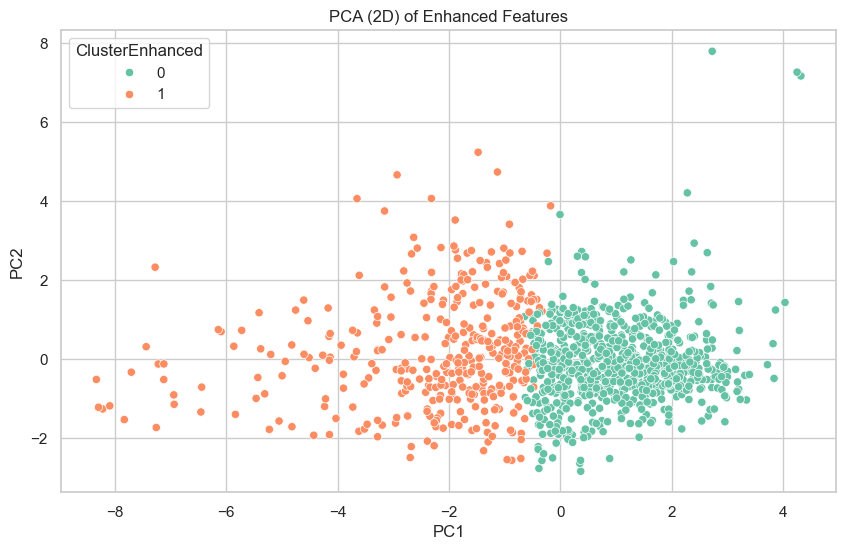

Explained variance ratio: [0.43796205 0.15039191]


In [12]:
# PCA projection of enhanced clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X2_pca = pca.fit_transform(X2)

pca_df = pd.DataFrame(X2_pca, columns=['PC1','PC2'], index=rfm_enhanced.index)
pca_df['ClusterEnhanced'] = rfm_enhanced['ClusterEnhanced']

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='ClusterEnhanced', palette='Set2')
plt.title('PCA (2D) of Enhanced Features')
plt.show()

print('Explained variance ratio:', pca.explained_variance_ratio_)

## Association Rule Mining (Optional)
Identify product bundles for cross-selling using Apriori and lift metric.

In [13]:
# Market Basket analysis using Apriori
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    # Build basket: rows = invoice, columns = product, values = 0/1
    if 'ProductList' in merged.columns and 'Invoice no' in merged.columns:
        basket = (merged[['Invoice no','ProductList']]
                        .dropna()
                        .drop_duplicates()
                        .assign(val=1)
                        .pivot_table(index='Invoice no', columns='ProductList', values='val', fill_value=0))
        # Frequent itemsets
        freq = apriori(basket, min_support=0.02, use_colnames=True)
        rules = association_rules(freq, metric='lift', min_threshold=1.1)
        rules = rules.sort_values('lift', ascending=False)
        display(rules.head(20)[['antecedents','consequents','support','confidence','lift']])
    else:
        print('ProductList or Invoice no column not found in merged; skipping Apriori.')
except ImportError:
    print('mlxtend is not installed. Run: pip install mlxtend')

a:\CCW\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
0,(P00270),(P00442),0.089236,0.944039,10.160102
1,(P00442),(P00270),0.089236,0.960396,10.160102
2,(P00387),(P00271),0.093836,0.978417,9.824846
3,(P00271),(P00387),0.093836,0.942263,9.824846


In [14]:
# Export enhanced results
rfm_enhanced_out = output_dir / 'rfm_clusters_enhanced.csv'
profile_enhanced_out = output_dir / 'cluster_profile_enhanced.csv'

rfm_enhanced.reset_index().rename(columns={'index':'Customer id'}).to_csv(rfm_enhanced_out, index=False)
profile_enhanced.to_csv(profile_enhanced_out)

print(f'Exported enhanced RFM with clusters -> {rfm_enhanced_out}')
print(f'Exported enhanced cluster profile -> {profile_enhanced_out}')

# Save top rules if available
try:
    if 'rules' in globals() and not rules.empty:
        rules_out = output_dir / 'assoc_rules_top.csv'
        rules.head(50)[['antecedents','consequents','support','confidence','lift']].to_csv(rules_out, index=False)
        print(f'Exported top association rules -> {rules_out}')
except Exception as e:
    print('Skipping rules export:', e)

Exported enhanced RFM with clusters -> output\rfm_clusters_enhanced.csv
Exported enhanced cluster profile -> output\cluster_profile_enhanced.csv
Exported top association rules -> output\assoc_rules_top.csv


In [15]:
# Generate persona table and actionable tactics from enhanced cluster profiles
from pathlib import Path

# Ensure output dir
output_dir = globals().get('output_dir', Path('output'))
output_dir.mkdir(exist_ok=True)

# Use rfm_enhanced and profile_enhanced already computed
rfm_df = rfm_enhanced.copy()
profile = profile_enhanced.copy()

# Compute dataset medians as thresholds
mon_med = rfm_df['Monetary'].median() if 'Monetary' in rfm_df.columns else rfm_df['MonetaryLog'].median()
freq_med = rfm_df['Frequency'].median()
rec_med = rfm_df['Recency'].median()

personas = []
for cluster in profile.index:
    row = profile.loc[cluster]
    # Fetch cluster-level metrics (fall back if column missing)
    mon = row['Monetary'] if 'Monetary' in row.index else rfm_df[rfm_df['ClusterEnhanced']==cluster]['Monetary'].mean()
    freq = row['Frequency'] if 'Frequency' in row.index else rfm_df[rfm_df['ClusterEnhanced']==cluster]['Frequency'].mean()
    rec = row['Recency'] if 'Recency' in row.index else rfm_df[rfm_df['ClusterEnhanced']==cluster]['Recency'].mean()
    cat_conc = row['CategoryConcentration'] if 'CategoryConcentration' in row.index else rfm_df[rfm_df['ClusterEnhanced']==cluster]['CategoryConcentration'].mean()
    mall_div = row['MallDiversity'] if 'MallDiversity' in row.index else rfm_df[rfm_df['ClusterEnhanced']==cluster]['MallDiversity'].mean()

    # Heuristic labeling
    if (mon >= mon_med) and (rec <= rec_med):
        label = 'High-Value (Recent)'
        traits = f'High monetary (≈{mon:.0f}), recent purchase (avg recency {rec:.0f} days)'
        acquisition = 'N/A — already high value; focus on upsell via exclusive bundles and referrals.'
        retention = 'VIP program, early access to new products, personalized premium promotions.'
    elif (freq >= freq_med) and (mon < mon_med):
        label = 'Frequent Low-Value'
        traits = f'High frequency (≈{freq:.1f}) but low monetary (≈{mon:.0f})'
        acquisition = 'Promote bundle upsell and cross-sell discounts to increase basket value (e.g., 10% off when adding accessory).'
        retention = 'Loyalty points for spending threshold; targeted value-add offers (e.g., buy 4 get 1).'
    else:
        label = 'Low-Value / Dormant'
        traits = f'Low frequency (≈{freq:.1f}), low monetary (≈{mon:.0f}), long recency (≈{rec:.0f} days)'
        acquisition = 'Welcome offer: first-purchase discount or bundle of top categories (use assoc_rules for combos).'
        retention = 'Re-engagement campaign: time-limited coupon + product recommendations based on past categories.'

    # Category loyalty note
    if cat_conc >= 0.6:
        traits += '; category-loyal'
        acquisition += ' Target similar-category lookalike audiences.'
        retention += ' Offer category-specific perks.'

    # Mall behavior note
    if mall_div <= 1.5:
        traits += '; mall-loyal (shops at few malls)'
        acquisition += ' Use store-level push promotions.'

    personas.append({
        'Cluster': int(cluster),
        'PersonaLabel': label,
        'Traits': traits,
        'AcquisitionTactic': acquisition,
        'RetentionTactic': retention,
        'SuggestedMetric': 'Conversion rate (acq), Repeat purchase rate (ret)'
    })

persona_df = pd.DataFrame(personas).set_index('Cluster')

display(persona_df)

# Export personas
persona_out = output_dir / 'personas_table.csv'
persona_df.to_csv(persona_out)
print(f'Exported persona table -> {persona_out}')

,PersonaLabel,Traits,AcquisitionTactic,RetentionTactic,SuggestedMetric
Cluster,,,,,
0,Low-Value / Dormant,"Low frequency (≈4.6), low monetary (≈58866), l...",Welcome offer: first-purchase discount or bund...,Re-engagement campaign: time-limited coupon + ...,"Conversion rate (acq), Repeat purchase rate (ret)"
1,Low-Value / Dormant,"Low frequency (≈2.0), low monetary (≈18080), l...",Welcome offer: first-purchase discount or bund...,Re-engagement campaign: time-limited coupon + ...,"Conversion rate (acq), Repeat purchase rate (ret)"


Exported persona table -> output\personas_table.csv
